In [2]:
import pandas as pd
import seaborn as sns
from utils_init import *
import matplotlib.pyplot as plt
from utils_error_analysis import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [3]:
#model_names =  ['bert','roberta','biobert','scibert']
#folds = range(0,10)
datasets=['cafeteria','hansard', 'foodon', 'snomedct']
#result_dir='results_10'
#fold_dir='folds_10'
#split='test'
#merged_all=get_merged_all(datasets, model_names, folds, result_dir, fold_dir, split)

In [4]:
merged_all = pd.read_csv('merged_datasets_cafeteria_hansard_foodon_snomedct.csv', index_col=0)
merged_all

/opt/conda/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,words,predictions,sentence_id,word_id,labels,full sentence,fold,model_name,dataset
0,The,O,0.0,0,O,The nutritional value of gluten - free product...,0,bert,cafeteria
1,nutritional,O,0.0,1,O,The nutritional value of gluten - free product...,0,bert,cafeteria
2,value,O,0.0,2,O,The nutritional value of gluten - free product...,0,bert,cafeteria
3,of,O,0.0,3,O,The nutritional value of gluten - free product...,0,bert,cafeteria
4,gluten,B,0.0,4,B,The nutritional value of gluten - free product...,0,bert,cafeteria
...,...,...,...,...,...,...,...,...,...
13570,development,O,4598.0,14,O,Many environmental and genetic factors are sus...,9,scibert,snomedct
13571,of,O,4598.0,15,O,Many environmental and genetic factors are sus...,9,scibert,snomedct
13572,the,O,4598.0,16,O,Many environmental and genetic factors are sus...,9,scibert,snomedct
13573,disease,O,4598.0,17,O,Many environmental and genetic factors are sus...,9,scibert,snomedct


labels
AG.01.aa         55
AG.01.ae          1
AG.01.d.04        1
AG.01.h         371
AG.01.h.02.b     38
AG.01.h.02.i     95
AG.01.m          33
AG.01.n         434
AG.01.n.03        3
AG.01.n.06       19
AG.01.n.07       38
AG.01.n.08       65
AG.01.n.09      194
AG.01.n.10      172
AG.01.n.12       16
AG.01.n.15       28
AG.01.n.16        3
AG.01.n.17       10
AG.01.n.18        9
Name: words, dtype: int64
(69, 69)
(20, 69)
(20, 50)
labels
http://purl.obolibrary.org/obo/CHEBI_24866;http://purl.obolibrary.org/obo/CHEBI_26710;http://purl.obolibrary.org/obo/CHEBI_15377;http://purl.obolibrary.org/obo/FOODON_00002340             1
http://purl.obolibrary.org/obo/CHEBI_28757;http://purl.obolibrary.org/obo/FOODON_03301061;http://purl.obolibrary.org/obo/NCBITaxon_381124;http://purl.obolibrary.org/obo/FOODON_03303225    6
http://purl.obolibrary.org/obo/CHEBI_28757;http://purl.obolibrary.org/obo/FOODON_03315552                                                                                    

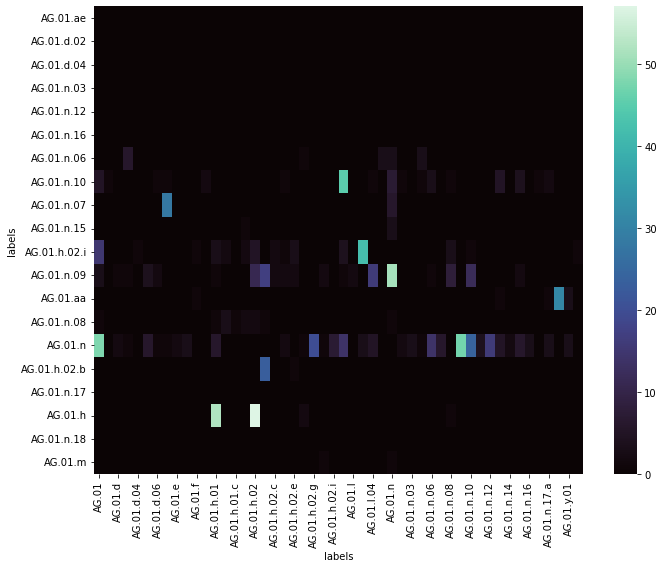

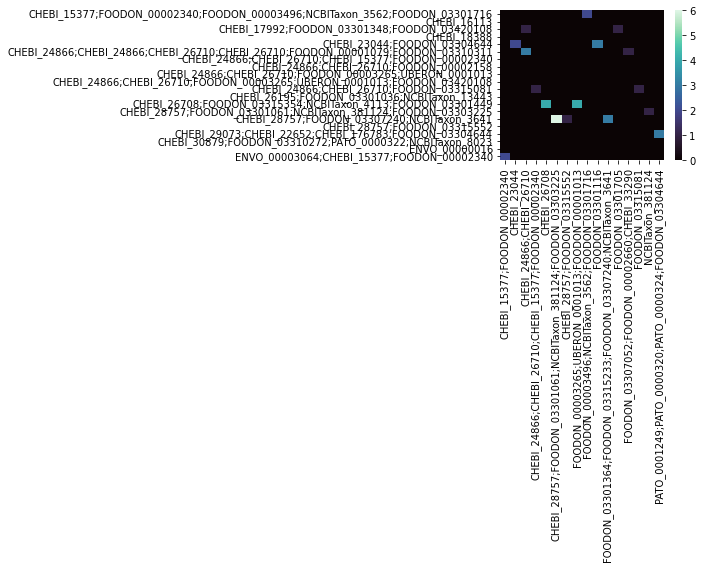

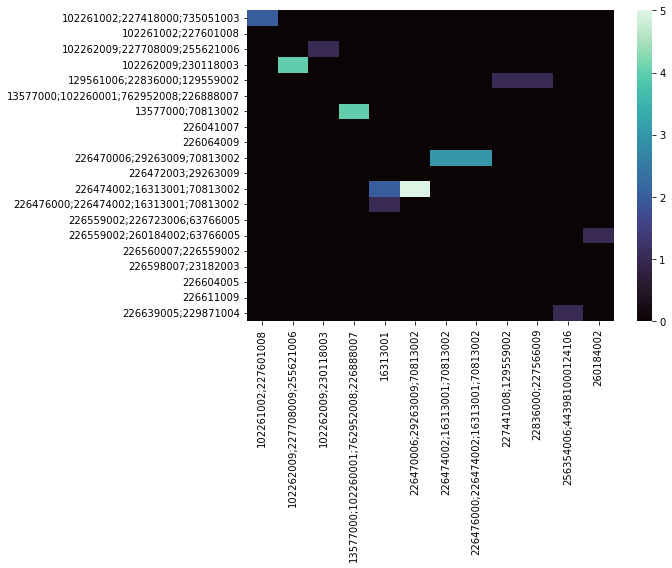

In [55]:
def filter_labels(df):
    labels_to_exclude=['O','macro avg','weighted avg','X','FOOD']
    return df.query("labels not in @labels_to_exclude and predictions not in @labels_to_exclude")

def remove_I_B_prefix(df):
    dfr = df.copy()
    dfr['labels'] = dfr['labels'].apply(lambda x: x.replace('B-','').replace('I-',''))
    dfr['predictions']=dfr['predictions'].apply(lambda x: x.replace('B-','').replace('I-',''))
    return dfr

def get_top_n_worse_f1_labels(df, n=20):
    #sorted_values = df['labels'].sort_values().drop_duplicates()
    #results = f1_score(df['labels'], df['predictions'], zero_division=0, average=None, labels=sorted_values)
    
    report = classification_report(df['labels'], df['predictions'], output_dict=True, zero_division=0)
    #print(report)
    
    f1_scores = []
    for key in df['labels'].unique():
    #    print(key, report[key]['f1-score'])
        f1_scores.append((report[key]['f1-score'], key))
    
    zip_list = sorted(f1_scores)
    
    #print(zip_list)
    #for a in zip_list[:20]:
    #    print(a)

    return [x[1] for x in zip_list][:n]


    
for dataset in ['hansard', 'foodon','snomedct']:
    merged_dataset = merged_all.query("dataset == @dataset").pipe(remove_I_B_prefix).pipe(filter_labels)
    
    # Keep labels with bad f1 score
    #keep_labels = get_top_n_worse_f1_labels(merged_dataset, n=20)
    
    
    sorted_values = merged_dataset['labels'].sort_values().drop_duplicates()
    confusion=confusion_matrix(merged_dataset['labels'], merged_dataset['predictions'], labels=sorted_values)
    confusion=pd.DataFrame(confusion, columns=sorted_values, index=sorted_values)
    
    keep_labels = get_top_n_worse_f1_labels(merged_dataset, n=20)
    print(merged_dataset.query("labels in @keep_labels and predictions in @keep_labels").groupby('labels').count()['words'])
    for i in range(0,confusion.shape[0]):
        for j in range(0,confusion.shape[1]):
            if i==j:
                confusion.iloc[i,j]=0
    print(confusion.shape)
    confusion = confusion[keep_labels].T
    print(confusion.shape)
    c=confusion.sum()
    
    c=c[c>0]
    keep_predictions=c.index
    confusion = confusion[keep_predictions]
    if dataset in ['snomedct','foodon']:
        confusion.index=[remove_link(x) for x in confusion.index]
        confusion.columns=[remove_link(x) for x in confusion.columns]
    print(confusion.shape)
    plt.figure(figsize=(10,8))
    sns.heatmap(data=confusion, cmap=sns.color_palette('mako', as_cmap=True))
    plt.tight_layout()
    plt.savefig(f'visualizations/{dataset}_confusion_filtered.pdf')

In [44]:
def remove_link(links_string):
    links=links_string.split(';')
    links = [l.split('/')[-1] for l in links]
    return ';'.join(links)

In [40]:
l = [remove_link(x) for x in confusion.index]

In [41]:
l

['SNOMEDCT 102261002;SNOMEDCT 227418000;SNOMEDCT 735051003',
 'SNOMEDCT 102261002;SNOMEDCT 227601008',
 'SNOMEDCT 102262009;SNOMEDCT 227708009;SNOMEDCT 255621006',
 'SNOMEDCT 102262009;SNOMEDCT 230118003',
 'SNOMEDCT 129561006;SNOMEDCT 22836000;SNOMEDCT 129559002',
 'SNOMEDCT 13577000;SNOMEDCT 102260001;SNOMEDCT 762952008;SNOMEDCT 226888007',
 'SNOMEDCT 13577000;SNOMEDCT 70813002',
 'SNOMEDCT 226041007',
 'SNOMEDCT 226064009',
 'SNOMEDCT 226470006;SNOMEDCT 29263009;SNOMEDCT 70813002',
 'SNOMEDCT 226472003;SNOMEDCT 29263009',
 'SNOMEDCT 226474002;SNOMEDCT 16313001;SNOMEDCT 70813002',
 'SNOMEDCT 226476000;SNOMEDCT 226474002;SNOMEDCT 16313001;SNOMEDCT 70813002',
 'SNOMEDCT 226559002;SNOMEDCT 226723006;SNOMEDCT 63766005',
 'SNOMEDCT 226559002;SNOMEDCT 260184002;SNOMEDCT 63766005',
 'SNOMEDCT 226560007;SNOMEDCT 226559002',
 'SNOMEDCT 226598007;SNOMEDCT 23182003',
 'SNOMEDCT 226604005',
 'SNOMEDCT 226611009',
 'SNOMEDCT 226639005;SNOMEDCT 229871004']

In [14]:
confusion.shape

(20, 69)

In [17]:
c=confusion.sum()
c=c[c>0]
c.index

(50,)

In [124]:
#confusion[keep_labels].T[keep_labels]

In [109]:
#merged_dataset.query("predictions == 'AG.01.aa'")
#f1_score(merged_dataset['labels'], merged_dataset['predictions'], zero_division=0, average=None)

In [114]:
#classification_report(merged_dataset['labels'], merged_dataset['predictions'], output_dict=True, zero_division=0)

In [62]:
#labels_to_exclude=['O','macro avg','weighted avg','X','FOOD']
#for dataset in ['hansard']:
#    merged_dataset=merged_all.query("labels not in @labels_to_exclude and predictions not in @labels_to_exclude and dataset == @dataset")
#    merged_dataset['labels']=merged_dataset['labels'].apply(lambda x: x.replace('B-','').replace('I-',''))
#    merged_dataset['predictions']=merged_dataset['predictions'].apply(lambda x: x.replace('B-','').replace('I-',''))
#    sorted_values = merged_dataset['labels'].sort_values().drop_duplicates()
#    confusion=confusion_matrix(merged_dataset['labels'], merged_dataset['predictions'], normalize='true', labels=sorted_values)
#    confusion=pd.DataFrame(confusion, columns= sorted_values, index=sorted_values)
#    plt.figure(figsize=(25,20))
#    sns.heatmap(data=confusion, cmap=sns.color_palette('mako', as_cmap=True))
#    #plt.savefig(f'visualizations/{dataset}_confusion.pdf')

In [5]:
#from sklearn.metrics import ConfusionMatrixDisplay
#plt.figure(figsize=(50,50))
#ConfusionMatrixDisplay.from_predictions(merged_hansard['labels'], merged_hansard['predictions'], normalize='true')
#plt.show()